Basic scikits-leaarn toolchain msetup

In [10]:
from multiprocessing import cpu_count

import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier as Classifier
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("../small.mplstyle")

/home/zah/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [11]:
RANDOM_SEED = 1001

In [12]:
signal = pd.DataFrame.from_csv('../ML_Events/signal/out_sig.txt', index_col= 0, sep='\t')
background = pd.DataFrame.from_csv('../ML_Events/background/out_bk.txt', index_col= 0, sep='\t')
signal.columns = background.columns = [s.strip() for s in signal.columns]

#Drop empy columns
emptycols = [c for c in signal.columns if c.startswith("Empty")]
signal.drop(emptycols, axis=1, inplace=True)
background.drop(emptycols, axis=1, inplace=True)

#Balance signal and background weights. Otherwise saying that everything is a signal is a cheap
#local minimum.
background.Weight *= signal.Weight.sum()/ background.Weight.sum()


data = pd.concat([signal, background])
features, weights = data.iloc[:, :-1], data.iloc[:,-1]
weights = np.abs(weights).as_matrix()
labels = np.r_[np.ones(len(signal)), np.zeros(len(background))]

#We split between testing and training by further starifying on weights, by ignoring the smaller ones for each
#category (for the purposes of splitting, we assign them to a third category '2' that tunrns out to be split evenly as well).
weighted_cats = labels.copy()
label_mask = labels.astype(bool)
small_signal = (weights < weights[label_mask].mean()) & label_mask
weighted_cats[small_signal] = 2

small_background = (weights < weights[~label_mask].mean()) & ~label_mask
weighted_cats[small_background] = 2


X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(features, labels, weights,
                                                                     random_state = RANDOM_SEED, 
                                                                     test_size=0.5, stratify=weighted_cats)



#X_train, y_train, w_train = features, labels, weights

cols = features.columns

(array([   3.,    2.,   11.,   57.,  117.,  199.,  440.,  448.,  716.,  669.]),
 array([-17.10343741, -15.18956331, -13.2756892 , -11.3618151 ,
         -9.447941  ,  -7.53406689,  -5.62019279,  -3.70631868,
         -1.79244458,   0.12142952,   2.03530363]),
 <a list of 10 Patch objects>)

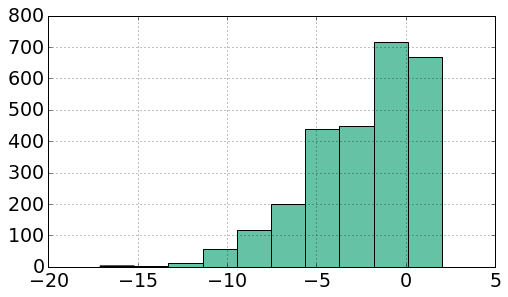

In [13]:
plt.hist(np.log10(weights))

In [14]:
len(data)

2662

In [15]:
sum(w_test)

2252.8113622554929

In [16]:
sum(w_train)

2140.0857696105859

In [17]:
sum(y_train*w_train)

1107.5629157999799

In [18]:
sum(y_test*w_test)

1100.6161157377237

In [19]:
len(cols)

17

In [20]:
clf = Classifier(n_estimators=1000, 
                 learning_rate=2,
                 #max_depth=10,
                 #criterion = "gini",
                 #max_features = 3,
                 min_weight_fraction_leaf=0.2,
                 #bootstrap = False,
                 #oob_score=True,
                 #class_weight="balanced_subsample",
                 #n_jobs=cpu_count(),
                 #subsample=0.3,
                 random_state=RANDOM_SEED)

In [21]:
clf.fit(X_train,y_train, sample_weight=w_train)

GradientBoostingClassifier(init=None, learning_rate=2, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.2, n_estimators=1000,
              presort='auto', random_state=1001, subsample=1.0, verbose=0,
              warm_start=False)

In [22]:
clf.score(X_test, y_test, sample_weight=w_test)

0.62859480747883623

In [23]:
clf.score(X_train, y_train, sample_weight=w_train)

0.71080619426218139

In [25]:
importances = clf.feature_importances_

In [26]:
import matplotlib.pyplot as plt

In [27]:
importances = pd.Series(importances, index=features.columns)

In [28]:
sv = importances.sort_values()
c,d = sv.index[-2:]

In [29]:
best_features = sv.index[-4:]

In [30]:
sv

W pT                             0.000000
mET phi                          0.000000
mET (scalar)                     0.000000
| Delta eta l1,l2 |              0.000000
m l1, l2                         0.000000
j1 pT                            0.000000
j2 pT                            0.000000
| Delta Phi l1, l2 |             0.000108
Cos |tot phi|                    0.000168
N of jets                        0.000328
dijet min distance               0.001430
Zeppenfeld Var                   0.001968
Centrality                       0.003126
Cos | deltaphi(j1+j2,l1+l2) |    0.004156
m j1, j2                         0.269385
Delta R j1,j2                    0.325820
| Delta eta j1,j2 |              0.393509
dtype: float64

In [31]:
best_features

Index(['Cos | deltaphi(j1+j2,l1+l2) |', 'm j1, j2', 'Delta R j1,j2',
       '| Delta eta j1,j2 |'],
      dtype='object')

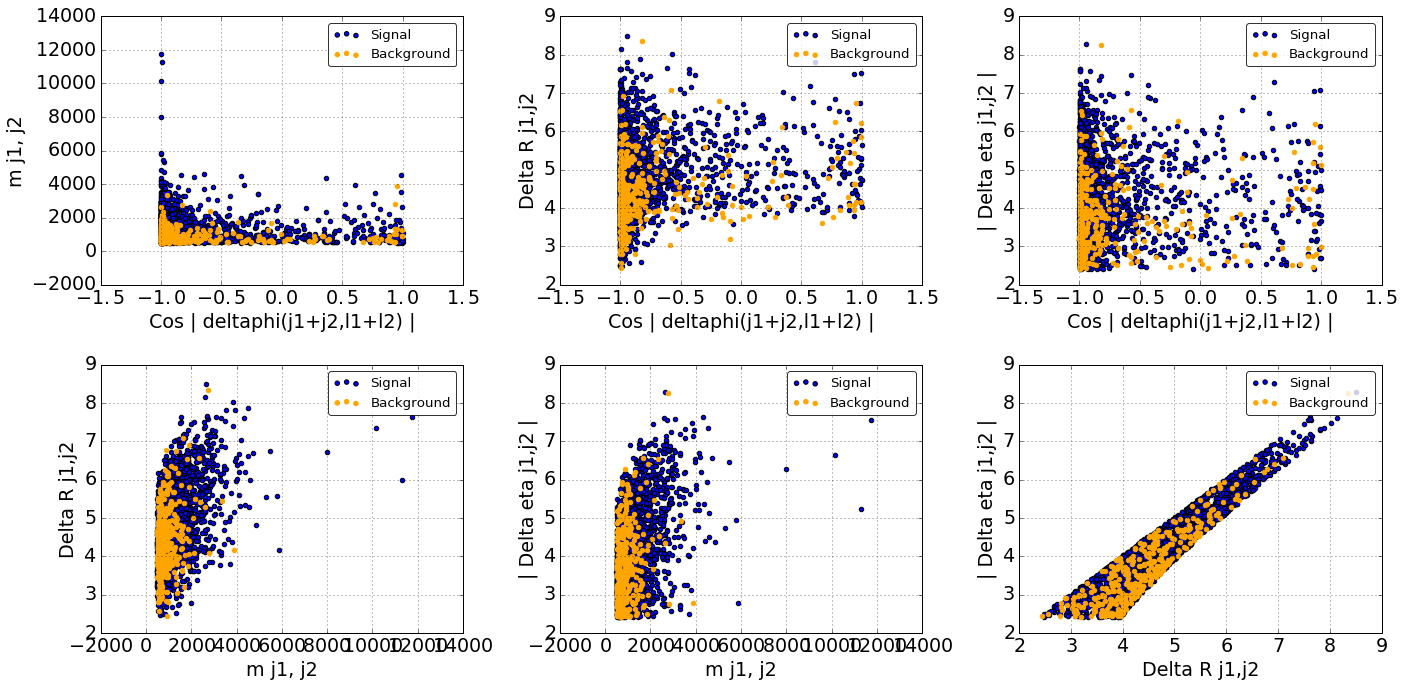

In [34]:
import itertools
pairs = (itertools.combinations(best_features,2))
fig, axes = plt.subplots(2,3, figsize=(20, 10))
axiter = (ax  for l in axes for ax in l)
for (c,d), ax in zip(pairs, axiter):
    ax.scatter(c,d, data=signal, label="Signal")
    ax.scatter(c,d, data=background, color='orange', label="Background")
    ax.set_xlabel(c)
    ax.set_ylabel(d)
    ax.legend(loc='best')
plt.tight_layout()
plt.savefig("features.pdf")
    

In [35]:
proba_test = clf.predict_proba(X_test)

In [36]:
import statsmodels.api as sm

In [37]:
cols

Index(['W pT', '| Delta eta j1,j2 |', 'Delta R j1,j2', 'm j1, j2', 'N of jets',
       'j1 pT', 'j2 pT', 'Centrality', '| Delta Phi l1, l2 |', 'm l1, l2',
       '| Delta eta l1,l2 |', 'mET (scalar)', 'mET phi', 'dijet min distance',
       'Zeppenfeld Var', 'Cos |tot phi|', 'Cos | deltaphi(j1+j2,l1+l2) |'],
      dtype='object')

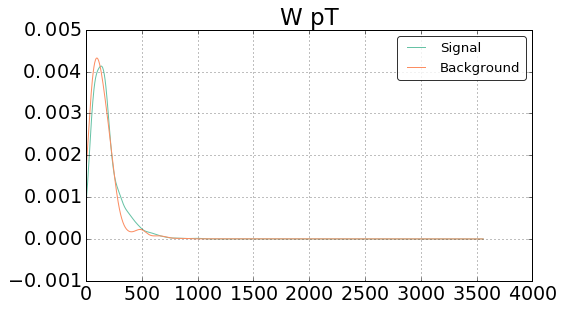

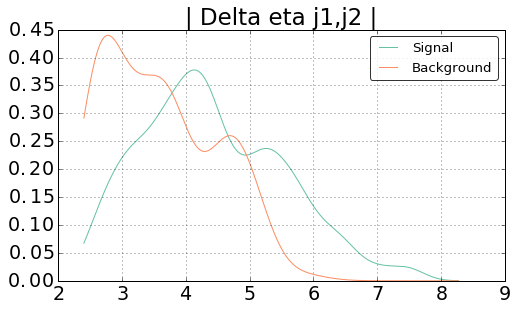

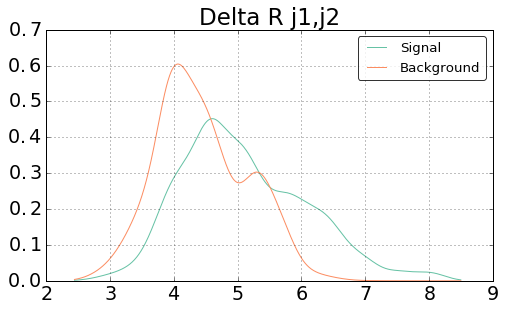

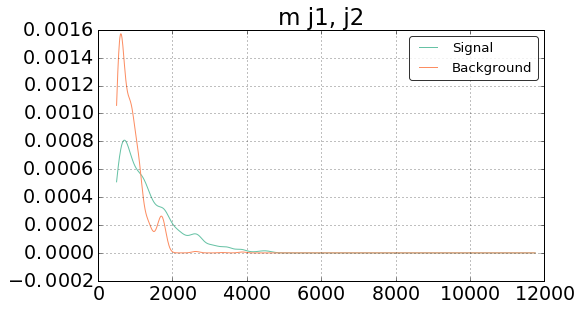

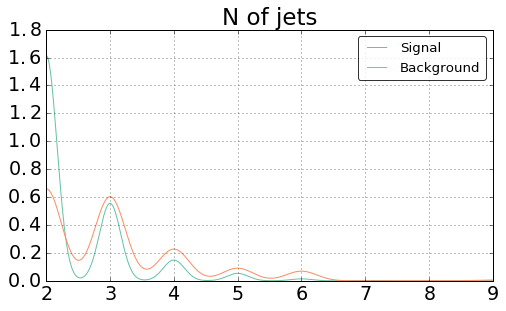

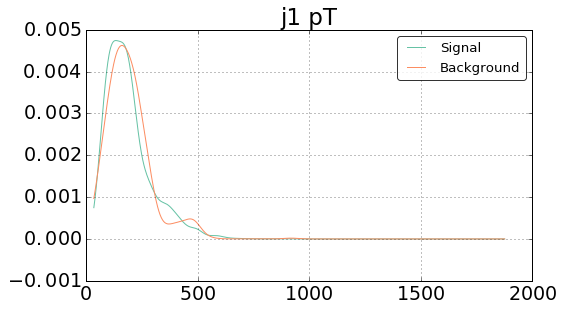

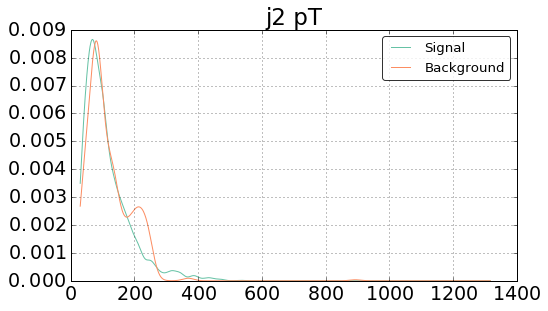

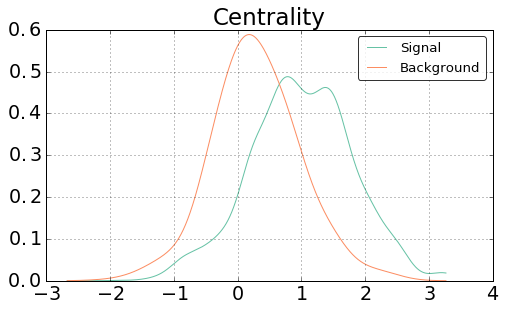

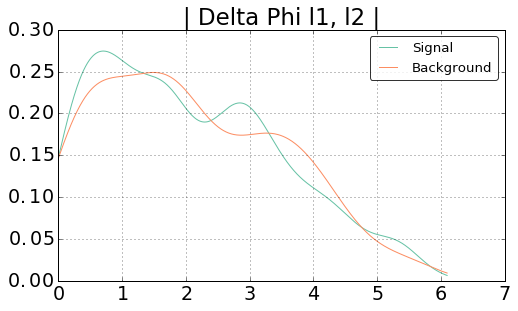

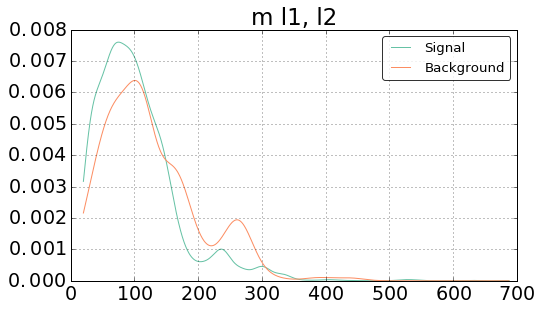

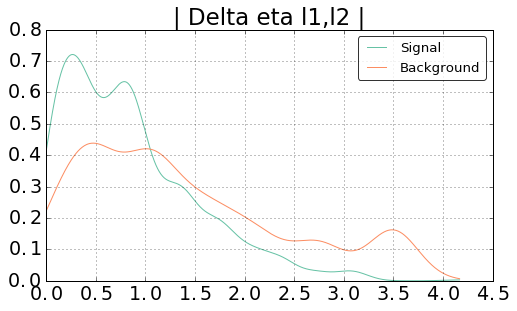

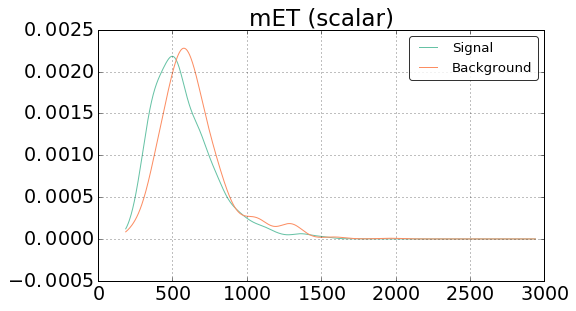

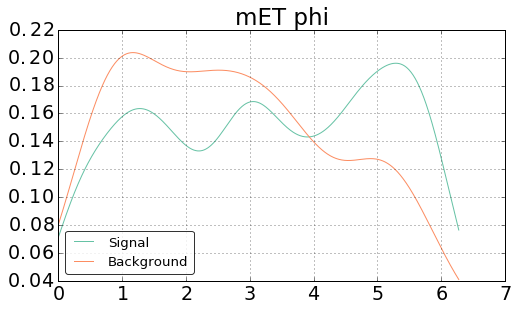

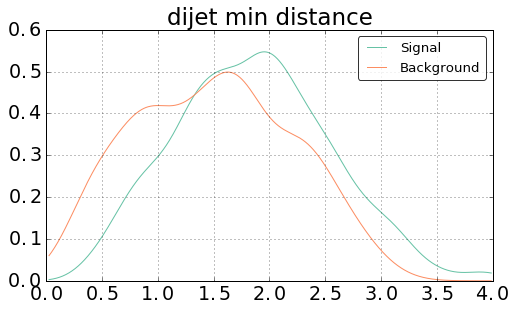

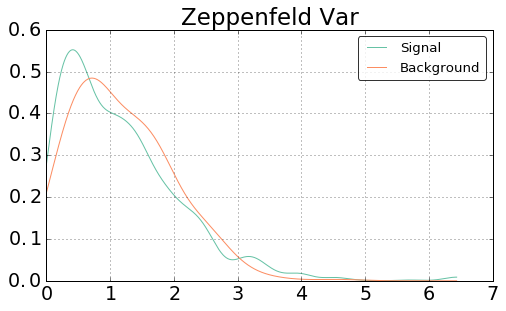

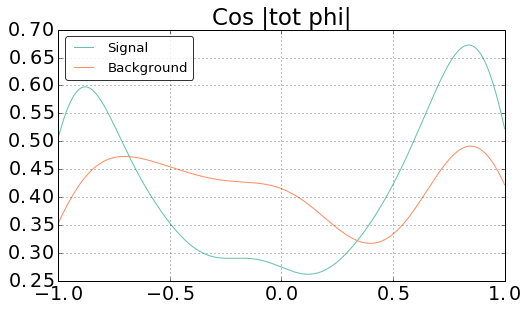

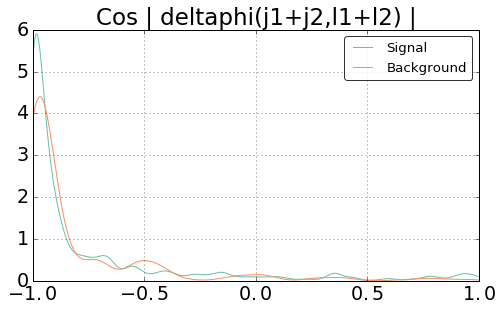

In [38]:
for feature in cols:
    
    dens_sig = sm.nonparametric.KDEUnivariate(signal[feature].as_matrix())
    dens_sig.fit(weights=signal.Weight.as_matrix(), fft=False)

    dens_bg= sm.nonparametric.KDEUnivariate(background[feature].as_matrix())
    dens_bg.fit(weights=background.Weight.as_matrix(), fft=False)
    plt.figure()
    plt.title(feature)
    
    x = np.linspace(data[feature].min(), data[feature].max(), 1000)
    plt.plot(x, dens_sig.evaluate(x), label="Signal")
    plt.plot(x, dens_bg.evaluate(x), label="Background")
    plt.legend()

In [99]:
predicted_test = clf.predict_proba(X_test)[:,1]
predicted_train = clf.predict_proba(X_train)[:,1]

In [100]:
from sklearn.metrics import roc_auc_score, roc_curve

In [101]:

fpr, tpr, thresholds = roc_curve(y_test, predicted_test, sample_weight=w_test)
#fpr, tpr, thresholds = roc_curve(y_train, predicted_train, sample_weight=w_train)

(0, 1)

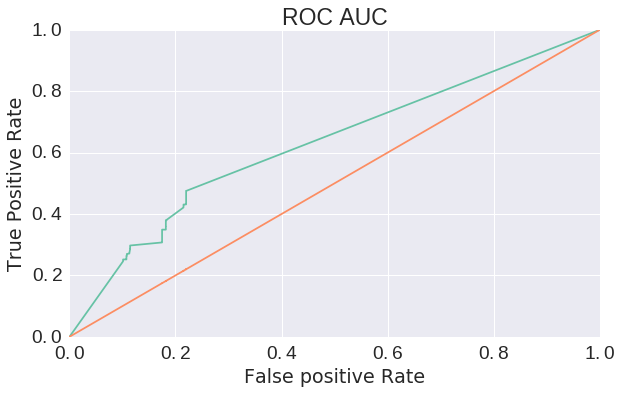

In [102]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title("ROC AUC")
plt.xlabel("False positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0,1)
plt.ylim(0,1)

In [103]:
roc_auc_score(y_test, predicted_test, sample_weight=w_test)

0.62820690191357276

In [104]:
probs = np.linspace(0,1,30)

In [105]:
clf.estimators_[0]

array([ DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.2,
           presort='auto',
           random_state=<mtrand.RandomState object at 0x7f42b7ea5860>,
           splitter='best')], dtype=object)

In [106]:
from sklearn.tree import export_graphviz

In [108]:
clf.predict_proba(signal[cols])[:,1];

In [7]:
sp = clf.predict_proba(signal[cols])[:,1]
bp = clf.predict_proba(background[cols])[:,1]

NameError: name 'clf' is not defined

In [6]:
plt.hist(sp, weights=signal.Weight, normed=True, bins=20)
plt.hist(bp, weights=background.Weight, normed=True, bins=20, alpha=0.5)

NameError: name 'sp' is not defined